## Install necessary modules

In [1]:
# !pip install pymatgen
# !pip install pymongo[srv]
# !pip install wget
# !pip install --upgrade openpyxl

## Make necessary imports

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import seaborn

import pymatgen
from pymatgen import core
import pandas as pd

from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler
import math

## Some helpful functions and classes

In [3]:
class data_generator(object):
  """ Creates a generator object from the compositions provided"""
  def __init__(self, comps):
        all_eles = []
        for c in comps:
            all_eles += list(c.get_el_amt_dict().keys())
        all_eles += ['O']
        self.eles = np.array(sorted(list(set(all_eles))))

        self.elements = self.eles
        self.size = len(self.eles)
        self.length = len(comps)

        all_vecs = np.zeros([len(comps), len(self.elements)])
        for i, c in enumerate(comps):
            for k, v in c.get_el_amt_dict().items():
                j = np.argwhere(self.eles == k)
                all_vecs[i, j] = v
        all_vecs = all_vecs / np.sum(all_vecs, axis=1).reshape(-1, 1)
        self.real_data = np.array(all_vecs, dtype=np.float32)

  def sample(self, N):
      """ Randomly sample compositions"""
      idx = np.random.choice(np.arange(self.length), N, replace=False)
      data = self.real_data[idx]

      return np.array(data, dtype=np.float32),idx
    
  def elements(self):
      """ Return all the elements present in the dataset"""
      return self.eles

In [4]:
def noise_sampler(N, z_dim):
  """ Draw a noisy array from a normally distributed space """
  return np.random.normal(size=[N, z_dim]).astype('float32')

In [5]:
def decode(vec, thresh=0.0):
    """ Creates a PyMatgen type composition object from a numpy array using elements present in the dataset """
    comp = ''
    for i, x in enumerate(vec):
        if x > thresh:
            comp += dset.elements[i] + '{:.2f} '.format(x)
    return core.Composition(comp)

In [6]:
import json
#import pymatgen as mg
import pandas as pd
#import math
from collections import defaultdict
import os

# excelFile = 'https://drive.google.com/uc?id=1GnLqcg5GlHK6lh5pLbUv3Sui8J8imMQC&export=download'
excelFile = "..\srf\FundemantalDescriptors_PureElements.xlsx"
metaDF = pd.read_excel(excelFile)
meta = metaDF.to_json(orient="split")
metaIndex = json.loads(meta)['columns']
metaParsed = json.loads(meta)['data']
meta_dict=defaultdict(dict)

def structure_choose(metaIndex_dict,meta_dict,material,n_index):
    metaIndex_update1={}
    for j,k in metaIndex_dict.items():
        comb_final=0
        data={}
        comb=0
        sum_comb=0
        if k>2:
            for o in material['compositionDictionary'].keys():
                if o not in meta_dict:
                    data[j] = None
                    break

                structure = ''
                if n_index != None:
                    s = n_index
                    structure = material['structure'][s]
                else:
                    try:
                        for a in meta_dict[o].keys():
                            int(a)
                            structure = meta_dict[o][a][1]
                    except:
                        structure='BCC'
                    #print('strucutre',material['compositionDictionary'],o,structure)

                try:
                    data[j]=meta_dict[o][structure][k]
                    float(data[j])
                    ##print('BCC')
                except:
                    ##print('No vaule for '+j+' of '+o+' for the phase in records, try other structures')
                    if structure=='BCC':
                        try:
                            data[j]=meta_dict[o]['FCC'][k]
                            float(data[j])
                            ##print('FCC')
                        except:
                            try:
                                data[j]=meta_dict[o]['HCP'][k]
                                float(data[j])
                                ##print('HCP')
                            except:
                                ##print('BREAk')
                                data[j] = None
                                break
    
                    elif structure=='FCC':
                        try:
                            data[j]=meta_dict[o]['HCP'][k]
                            float(data[j])
                        except:
                            try:
                                data[j]=meta_dict[o]['BCC'][k]
                                float(data[j])
                            except:
                                data[j] = None
                                break
                    elif structure=='HCP':
                        try:
                            data[j]=meta_dict[o]['FCC'][k]
                            float(data[j])
                        except:
                            try:
                                data[j]=meta_dict[o]['BCC'][k]
                                float(data[j])
                            except:
                                data[j] = None
                                break
                    elif structure=='Others':
                        try:
                            data[j]=meta_dict[o]['BCC'][k]
                            float(data[j])
                            #print('others','BCC')
                        except:
                            try:
                                data[j]=meta_dict[o]['FCC'][k]
                                float(data[j])
                                #print('others','FCC')
                            except:
                                try:
                                    data[j]=meta_dict[o]['HCP'][k]
                                    float(data[j])
                                    #print('others','HCP')
                                except:
                                    data[j] = None
                                    break
                

                ##print('data',comb,i['material']['compositionDictionary'][o])
                comb=comb+material['compositionDictionary'][o]*data[j]
                
                sum_comb=sum_comb+material['compositionDictionary'][o]
                        
            if data[j] != None:
                metaIndex_update1[j] = round(float(comb/sum_comb),6)
            else:
                metaIndex_update1[j] = None

    ##print(metaIndex_update1)
    return metaIndex_update1

def structure_calculate(metaIndex_dict,meta_dict,material):
    all_structure=['BCC','FCC','HCP']
    result=[]
    n = 0
    n_index=[]
    try:
        for i in range(len(material['structure'])):
            if material['structure'][i] in all_structure:
                n=n+1
                n_index.append(i) 
        #print('n and st',n)
    except:
        pass
    if n>1:
        #print('n_value',material['formula'],material['structure'][n_index[0]])
        for s in n_index:
            singleResult = structure_choose(metaIndex_dict,meta_dict,material,s)
            singleResult['structure'] = material['structure'][s]
            result.append(singleResult)
    elif n==1:
        #print('n_value1',material['formula'],material['structure'][n_index[0]])
        singleResult = structure_choose(metaIndex_dict,meta_dict,material,n_index[0])
        singleResult['structure'] = material['structure'][n_index[0]]
        result.append(singleResult)
    elif n==0:
        #print('n_value0',material['formula'])
        singleResult = structure_choose(metaIndex_dict, meta_dict, material, None)
        singleResult['structure'] = '?'
        result.append(singleResult)
    ##print(metaIndex_update)
    return result


def linear_combination_run(data):
    
    metaIndex_dict={}
    for k in metaParsed:
        meta_dict[k[2]][k[0]]=k
    ##print(metaIndex,meta_dict)
    for j in range(len(metaIndex)):
        metaIndex_dict[metaIndex[j]] = j
    result = structure_calculate(metaIndex_dict,meta_dict,data['material'])
    return result

In [7]:
def FT_Rice_92(Shear_Modulus,Unstable_Stacking_Fault_Energy,Poisson_Ratio ):
    if None in [Unstable_Stacking_Fault_Energy, Shear_Modulus, Poisson_Ratio]:
        return None
    else:
        return math.sqrt(2*Shear_Modulus*Unstable_Stacking_Fault_Energy/(1-Poisson_Ratio))

In [8]:
def get_sm_ft_vals(compositions):
  """ get the shear modulus and fracture toughness values from compositions in Pymatgen format"""
  ft_val_list = []
  sm_val_list = []
  ks = {}
  for i in range(len(compositions)):
    temp = {}
    temp['formula'] = compositions[i].formula
    temp['compositionDictionary']=compositions[i].as_dict()
    temp['reducedFormula']= compositions[i].reduced_formula
    temp['structure']=['?']
    ks['material']=temp
    LCR = linear_combination_run(ks)
    ft_val = FT_Rice_92(LCR[0]['DFTGh'],LCR[0]['USFE'],LCR[0]['DFTpoisson'])
    ft_val_list.append(ft_val)
    sm_val_list.append(LCR[0]['DFTGh'])
  return sm_val_list,ft_val_list

In [9]:
if torch.cuda.is_available():
    cuda = True
    os.environ['CUDA_VISIBLE_DEVICES'] = "0"
else:
    cuda = False

##Visualization functions

In [10]:
def fig_plot(points, dset, thresh=0.03):

    fig, axes = plt.subplots(1, 4, figsize=(25, 5))
    ax=axes[0]
    ax.violinplot(points, np.arange(points.shape[1]))
    ax.set_xticks(np.arange(dset.size))
    ax.set_xticklabels(dset.elements,rotation=45)
    ax.set_xlabel('Elements')
    ax.set_ylabel('Frequency')
    s = points.sum(axis=1)
    ax=axes[1]
    if np.max(s) - np.min(s) < 0.1:
        ax.hist(s, np.linspace(0.9, 1.1, 6))
    else:
        ax.hist(s)
    ax.set_xlabel('Sum of fractions')
    ax.set_ylabel('Frequency')
    ax = axes[2]
    ax.hist(points.flatten())
    ax.set_xlabel('Elemental fraction')
    ax.set_ylabel('Frequency')
    ne = (points > thresh).sum(axis=1)
    ax = axes[3]
    ax.hist(ne, np.arange(0, 17), width=0.80)
    ax.set_xlabel('Number of elements')
    ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()
    plt.close()

## Download CSV file containing data

In [11]:
filename = 'https://drive.google.com/uc?id=1-2Ia30pDDiRgof0FFinN4EQ-1BN24qld&export=download'
df = pd.read_csv(filename,index_col=0)

In [12]:
df

,Composition,Shear modulus,Fracture toughness
0,Be5.5 Ti10.5 Mo10.5 Cr10.5 Fe10.5 Co10.5 Ni10....,58.825500,10.604205
1,Cr14.3 Fe14.3 Co14.3 Ni14.3 Al42.8,54.499199,9.250585
2,Cr1 Mn1 Fe1 Co1 Ni1,75.519997,11.330024
3,Cr20 Mn20 Fe20 Co20 Ni21,75.500992,11.299732
4,Cr10 Mn10 Fe10 Co10 Ni11,75.482353,11.269974
...,...,...,...
524,Hf0.9 Mo91,19.804789,21.160252
525,Hf1.5 Mo98.5,19.860500,21.074387
526,Hf3 Mo97,20.021000,20.826691
527,Hf0.1 Ti0.5 Ta5 W5 Mo1 Cr4 Re4 Ru4 Ni70.3 Al6 ...,81.609200,10.414715


In [13]:
comps = [core.Composition(x) for x in df['Composition']]
prop_vals = df.iloc[:,1:].values.astype('float32')

In [14]:
comps

[Comp: Ti10.5 Be5.5 Al10.5 Cr10.5 Fe10.5 Co10.5 Cu10.5 Si10.5 Ni10.5 Mo10.5,
 Comp: Al42.8 Cr14.3 Fe14.3 Co14.3 Ni14.3,
 Comp: Mn1 Cr1 Fe1 Co1 Ni1,
 Comp: Mn20 Cr20 Fe20 Co20 Ni21,
 Comp: Mn10 Cr10 Fe10 Co10 Ni11,
 Comp: Al16.7 Cr16.7 Fe16.7 Cu16.7 Ni33.2,
 Comp: Al16.7 Cr16.7 Fe16.7 Cu16.8 Ni33.2,
 Comp: Ti5.9 Al5.9 Cr29.4 Fe29.4 Ni29.4,
 Comp: Al18 Cr21 Fe20 Co20 Ni21,
 Comp: Al15.5 Cr22.25 Fe20 Co20 Ni22.25,
 Comp: Al13 Cr23.5 Fe20 Co20 Ni23.5,
 Comp: Cr1 Co1 Ni1,
 Comp: Ta1 Nb1 Mo1 W1,
 Comp: Zr1 Ta1 Ti1 Nb1,
 Comp: Zr23.75 Ta23.75 Ti23.75 Nb23.75 Mo5,
 Comp: Zr22.5 Ta22.5 Ti22.5 Nb22.5 Mo10,
 Comp: Zr1 Ta1 Ti1 Nb1 Mo1,
 Comp: V2 Cr2 Fe9 Co4 Ni3,
 Comp: Ta1 Ti1 Nb1 V1,
 Comp: Zr41.2 Ti13.8 Be22.5 Cu12.5 Ni10,
 Comp: Fe0.86 Ni2.01 W97.13,
 Comp: Fe2.19 Ni5.33 W92.5,
 Comp: Fe2.95 Ni6.78 W90,
 Comp: Fe1.49 Ni3.48 W95,
 Comp: Hf4 Ti26 Nb51 Al2 Cr2 Si15,
 Comp: Ti27 Nb41 Al9 Cr8 Si15,
 Comp: Nb83.5 Si16.5,
 Comp: Nb9 Si1,
 Comp: Ti42.5 Nb42.5 Si15,
 Comp: Ti8 Nb8 Al1 Si3,
 Comp: Fe1 Co

In [15]:
prop_vals

array([[58.8255  , 10.604205],
       [54.4992  ,  9.250585],
       [75.52    , 11.330024],
       ...,
       [20.021   , 20.82669 ],
       [81.6092  , 10.414715],
       [73.5243  , 10.826843]], dtype=float32)

Scale property values using StandardScaler

In [16]:
scaler = StandardScaler()
prop_vals_scaled = scaler.fit_transform(prop_vals)

Do a Kernel Density Estimation for creating a probability distribution of the property values for sampling

In [17]:
from sklearn.neighbors import KernelDensity
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
v = kde.fit(prop_vals_scaled)
kde.sample(10) #samples 10 property values using the probability distribution of the properties

array([[-0.95835669,  0.75246775],
       [-1.0367799 ,  1.67612543],
       [ 0.02887245, -0.08951921],
       [ 1.10442832,  0.59466679],
       [ 2.32501117,  0.73337196],
       [ 0.50361932, -0.42129017],
       [ 0.17150478, -0.53398057],
       [-0.41842198, -1.10633552],
       [-0.88704377,  0.07069702],
       [-0.05594038,  0.87997438]])

Create data_generator object for randomly sampling vectorized compositions from dataset 

In [18]:
dset = data_generator(comps)
dset.sample(10) #samples 10 compositions from the dataset (remider : sample returns compositions + its index in dataset)

(array([[0.09      , 0.        , 0.        , 0.08      , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.41      , 0.        , 0.        , 0.        , 0.        ,
         0.15      , 0.        , 0.27      , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.27272728,
         0.18181819, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.18181819, 0.18181819, 0.        ,
         0.        , 0.18181819],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.75      , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.25      , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
 

## Autoencoder Structure

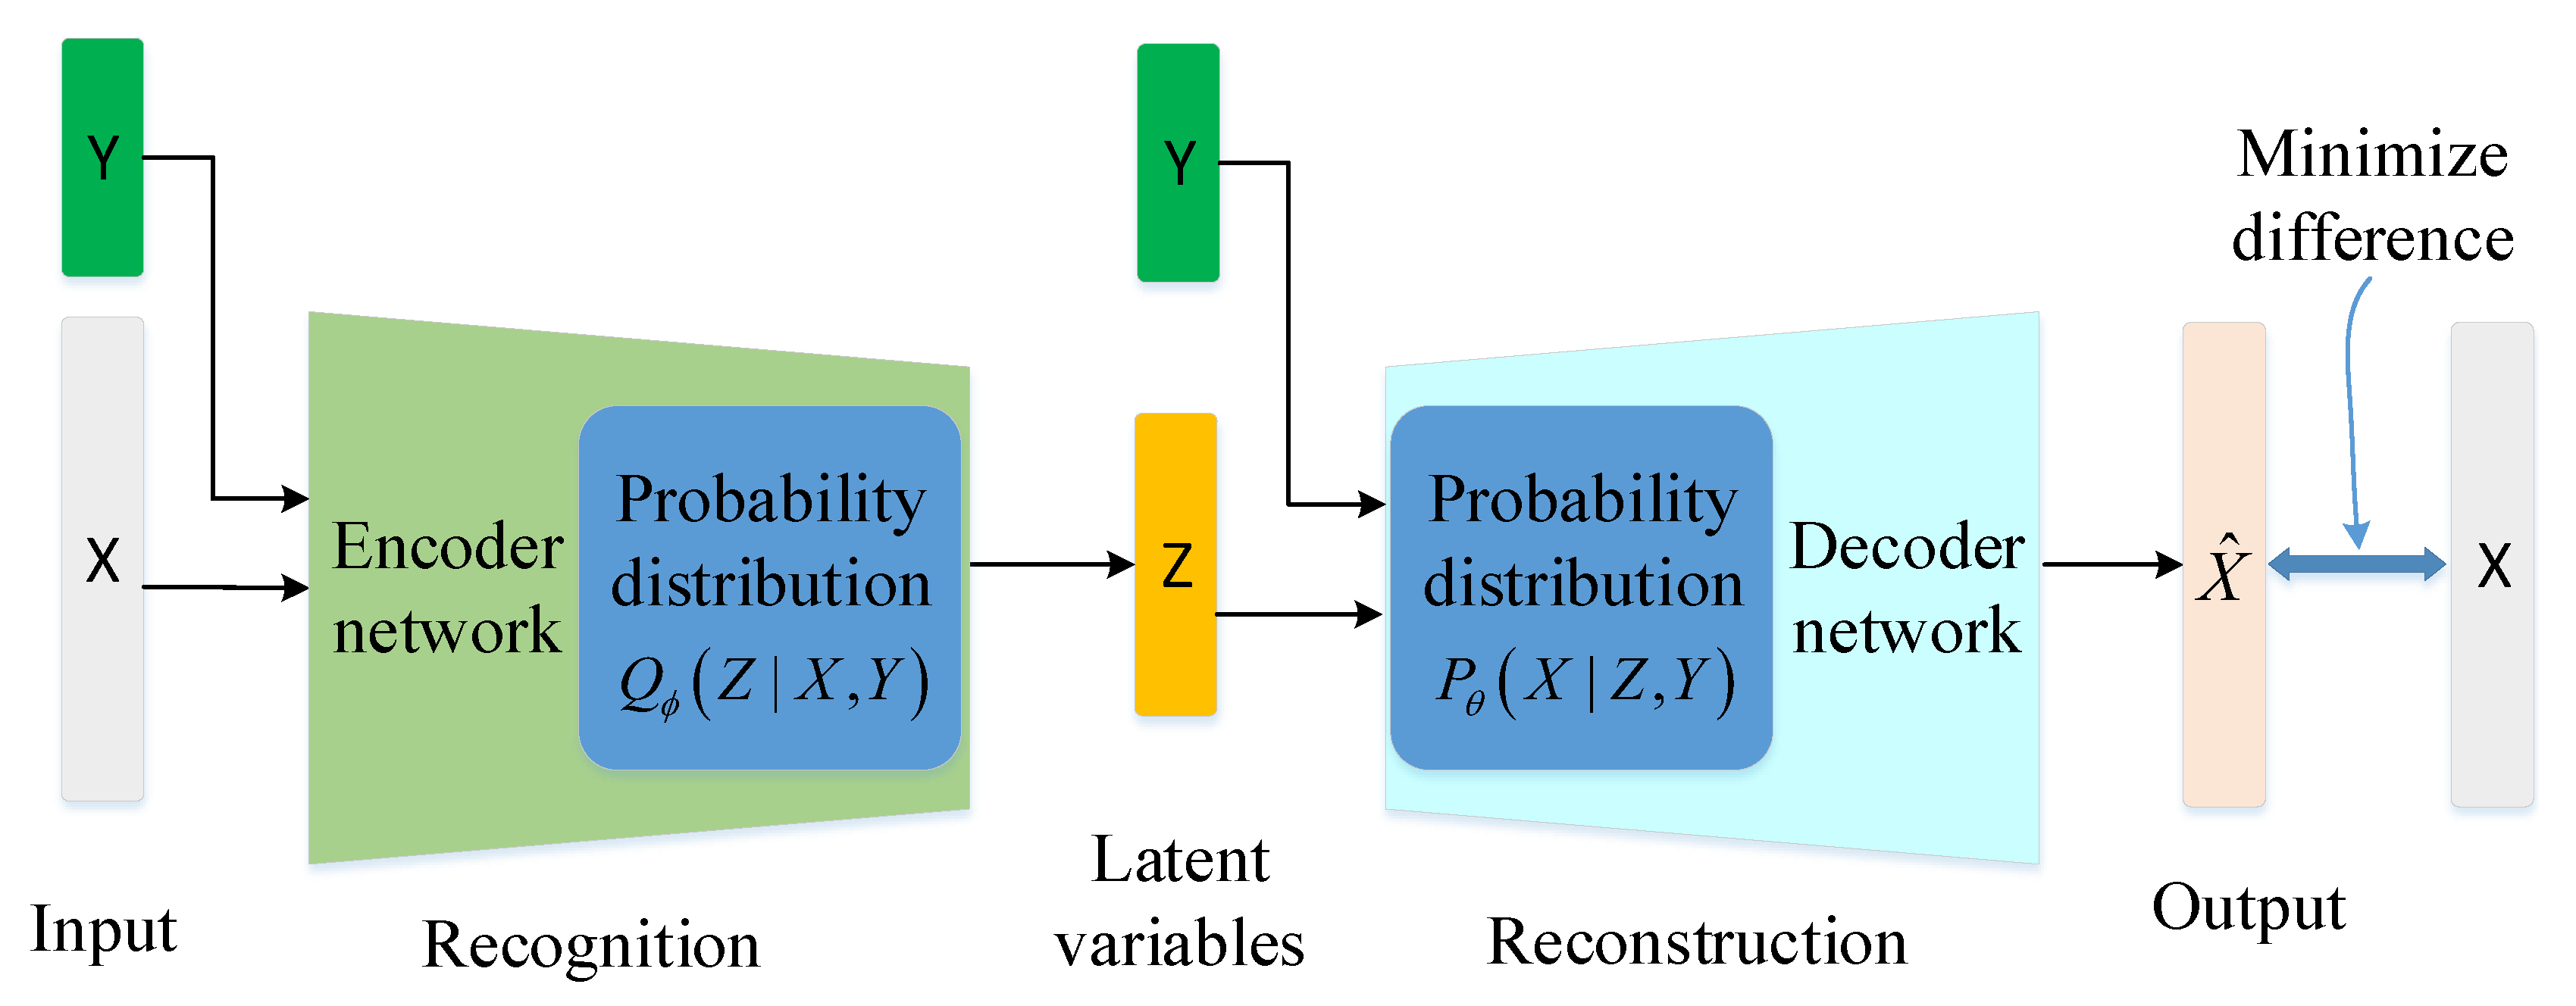

In [19]:
class surrogatemodel_ANN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(22,15)    # linear layer
        self.fc2 = nn.Linear(15,8)    # linear layer
        self.fc3 = nn.Linear(8,4)    # linear layer
        self.fc4 = nn.Linear(4,2)    # linear layer
        self.act = torch.nn.ReLU()  # activation function

    def forward(self, x):
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.fc4(x)
        return x

In [20]:
class cAE(torch.nn.Module):
  def __init__(self,nx,nz):
    super().__init__()

    self.encoder=torch.nn.Sequential(
        torch.nn.Linear(nx+2,64),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(64,32),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(32,16),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(16,nz),
    )

    self.decoder=torch.nn.Sequential(
        torch.nn.Linear(nz+2,16),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(16,32),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(32,64),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(64,nx),
    )

  def encode(self,x,conditions):
    x = torch.cat((x,conditions),dim=1)
    return self.encoder(x)

  def decode(self,x,conditions):
    x = torch.cat((x,conditions),dim=1)
    return self.decoder(x)
  
  def forward(self,x,conditions):
    x=self.encode(x,conditions)
    x=self.decode(x,conditions)
    return x

In [21]:
Conditionst_ys = torch.from_numpy(prop_vals_scaled)
s_ANN = surrogatemodel_ANN()
Xt=torch.Tensor(dset.real_data)
optimizer=torch.optim.Adam(params = s_ANN.parameters())
Loss=torch.nn.MSELoss()
epoches=2000
from tqdm.notebook import tqdm
for epoch in tqdm(range(epoches)):
  optimizer.zero_grad()
  y_predit = s_ANN(Xt)
  loss=Loss(y_predit,Conditionst_ys)
  if((epoch+1)%100==0):
    print('epoch: {}, Loss:{}'.format(epoch+1 ,loss))
  loss.backward()
  optimizer.step()

  0%|          | 0/2000 [00:00<?, ?it/s]

epoch: 100, Loss:1.0079892873764038
epoch: 200, Loss:0.6307565569877625
epoch: 300, Loss:0.39994773268699646
epoch: 400, Loss:0.310116171836853
epoch: 500, Loss:0.2120956927537918
epoch: 600, Loss:0.14656245708465576
epoch: 700, Loss:0.10830065608024597
epoch: 800, Loss:0.08208309859037399
epoch: 900, Loss:0.06242544949054718
epoch: 1000, Loss:0.047968145459890366
epoch: 1100, Loss:0.0375434085726738
epoch: 1200, Loss:0.029957091435790062
epoch: 1300, Loss:0.0243549607694149
epoch: 1400, Loss:0.020077744498848915
epoch: 1500, Loss:0.01675860956311226
epoch: 1600, Loss:0.014156065881252289
epoch: 1700, Loss:0.012069142423570156
epoch: 1800, Loss:0.010378346778452396
epoch: 1900, Loss:0.00899051409214735
epoch: 2000, Loss:0.007867172360420227


In [22]:
Xt=torch.Tensor(dset.real_data)
model=cAE(Xt.shape[1],5)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
Loss=torch.nn.MSELoss()
epoches=1000

In [23]:
for epoch in tqdm(range(epoches)):
  optimizer.zero_grad()
  X_predit = model(Xt,Conditionst_ys)
  loss=Loss(X_predit,Xt)
  if((epoch+1)%100==0):
    print('epoch: {}, Loss:{}'.format(epoch+1 ,loss))
  loss.backward()
  optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch: 100, Loss:0.005167837254703045
epoch: 200, Loss:0.0022862788755446672
epoch: 300, Loss:0.0011948716128244996
epoch: 400, Loss:0.0008822256349958479
epoch: 500, Loss:0.000687343708705157
epoch: 600, Loss:0.0005684104398824275
epoch: 700, Loss:0.00048090607742778957
epoch: 800, Loss:0.0004190729814581573
epoch: 900, Loss:0.00036865935544483364
epoch: 1000, Loss:0.00033324884134344757


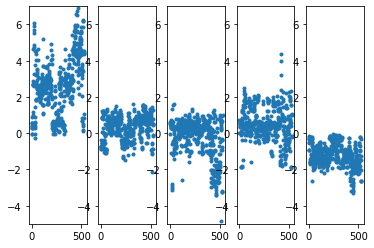

In [24]:
a_pred=model.encode(Xt,Conditionst_ys).detach().numpy()
fig,axes=plt.subplots(1,5)
for i in range(5):
  axes[i].plot(a_pred[:, i], '.')
  axes[i].set_ylim(-5,7)

In [25]:
def randarray(dim,latent_points,conditions):
  temp_ans_latent = np.zeros((5))
  ans_latent = np.zeros((dim,5))
  for j in range(dim):
    for i in range(5):
      temp = (max(latent_points[:,i])-min(latent_points[:,i]))*np.random.rand(1)+min(latent_points[:,i])
      temp_ans_latent[i] = temp
    ans_latent[j] = temp_ans_latent

  return ans_latent

In [26]:
def cond(split,dim,toughness_range,shear_range):
  ans = np.zeros((split-1,dim,2))
  for i in range(split-1):
    for j in range(dim):
      ans[i,j,0] = (max(toughness_range)-min(toughness_range))/split*(i+1)
      ans[i,j,1] = (max(shear_range)-min(shear_range))/split*(i+1)
  return ans

## Compare with input and output

In [27]:
inputlatent = torch.from_numpy(randarray(529,a_pred,prop_vals_scaled)).float()
inputcond = cond(10,10,prop_vals[:,0],prop_vals[:,1]).astype('float32')

In [28]:
outputcomp = model.decode(inputlatent,Conditionst_ys).detach().numpy()

In [29]:
Frominput = model.forward(Xt,Conditionst_ys).detach().numpy()

 Text(0, 0, 'input'),
 Text(0, 1, 'output'),
 Text(0, 0, 'Al'),
 Text(1, 0, 'Be'),
 Text(2, 0, 'Co'),
 Text(3, 0, 'Cr'),
 Text(4, 0, 'Cu'),
 Text(5, 0, 'Fe'),
 Text(6, 0, 'Hf'),
 Text(7, 0, 'Ir'),
 Text(8, 0, 'Mn'),
 Text(9, 0, 'Mo'),
 Text(10, 0, 'Nb'),
 Text(11, 0, 'Ni'),
 Text(12, 0, 'O'),
 Text(13, 0, 'Re'),
 Text(14, 0, 'Ru'),
 Text(15, 0, 'Si'),
 Text(16, 0, 'Ta'),
 Text(17, 0, 'Ti'),
 Text(18, 0, 'V'),
 Text(19, 0, 'W'),
 Text(20, 0, 'Y'),
 Text(21, 0, 'Zr'),
 Text(0, 0, 'input'),
 Text(0, 1, 'output'),
 Text(0, 0, 'Al'),
 Text(1, 0, 'Be'),
 Text(2, 0, 'Co'),
 Text(3, 0, 'Cr'),
 Text(4, 0, 'Cu'),
 Text(5, 0, 'Fe'),
 Text(6, 0, 'Hf'),
 Text(7, 0, 'Ir'),
 Text(8, 0, 'Mn'),
 Text(9, 0, 'Mo'),
 Text(10, 0, 'Nb'),
 Text(11, 0, 'Ni'),
 Text(12, 0, 'O'),
 Text(13, 0, 'Re'),
 Text(14, 0, 'Ru'),
 Text(15, 0, 'Si'),
 Text(16, 0, 'Ta'),
 Text(17, 0, 'Ti'),
 Text(18, 0, 'V'),
 Text(19, 0, 'W'),
 Text(20, 0, 'Y'),
 Text(21, 0, 'Zr'),
 Text(0, 0, 'input'),
 Text(0, 1, 'output'),
 Text(0, 0, '

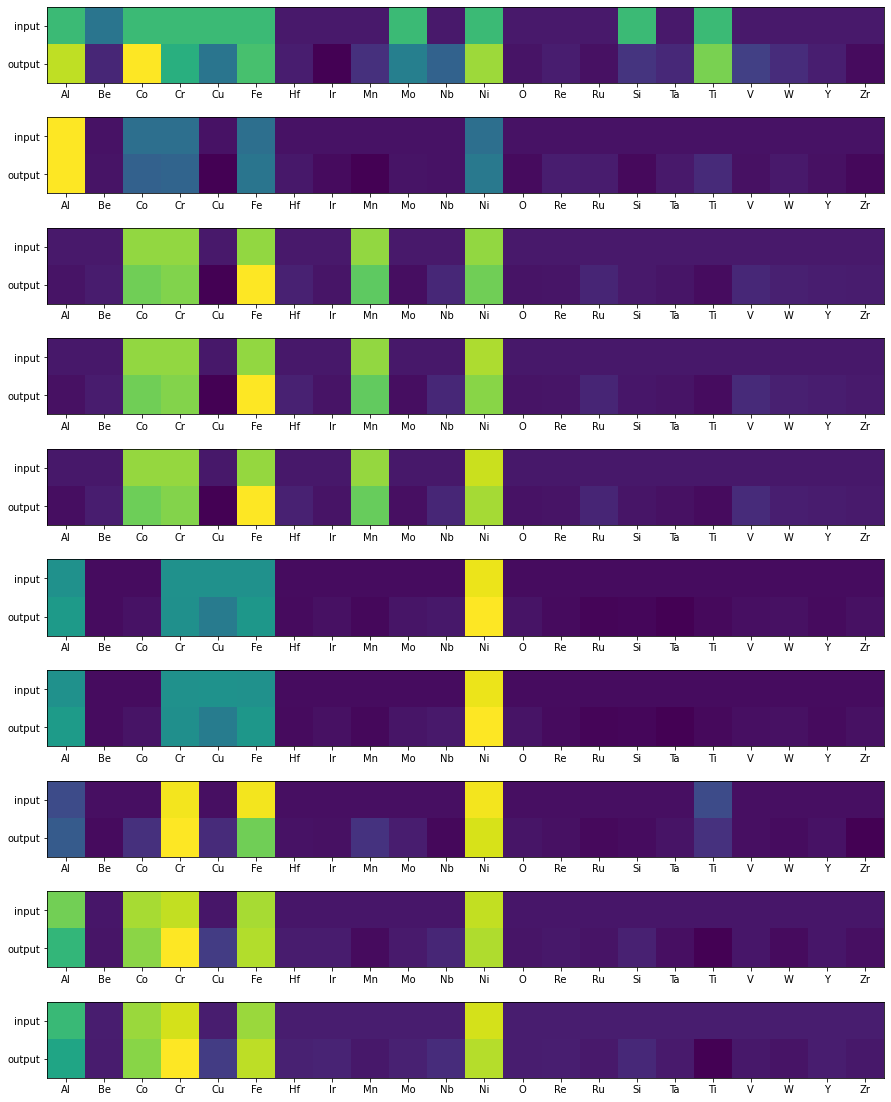

In [30]:
size = 1
FIGS,AXES = plt.subplots(10*size,1,figsize=(15,20*size))
for i in range(10*size):
  AXES[i].imshow(np.vstack((Xt[i].detach().numpy(),Frominput[i])))

plt.setp(AXES,yticks=[0,1],yticklabels = ["input","output"],xticks=[i for i in range(22)],xticklabels=dset.elements)

In [31]:
s_ANN(torch.from_numpy(outputcomp)).detach().numpy()

array([[ 0.16514748, -0.07321548],
       [-0.18787092, -0.6270396 ],
       [ 1.6756685 ,  0.08404887],
       ...,
       [-1.3080894 ,  1.1608884 ],
       [ 0.4796375 , -0.29519755],
       [ 0.13044655, -0.4348387 ]], dtype=float32)

In [32]:
for i in range(30):
  print(i)
  print(scaler.inverse_transform(s_ANN(torch.from_numpy(outputcomp[i]).reshape(1,22)).detach().numpy()))
  print(scaler.inverse_transform(s_ANN(torch.from_numpy(Frominput[i]).reshape(1,22)).detach().numpy()))
  print('\n')

0
[[66.748375 10.908654]]
[[56.522526  9.7974  ]]


1
[[57.180443  8.198064]]
[[56.38437   9.323742]]


2
[[107.68839   11.678355]]
[[77.14888  11.620042]]


3
[[74.64025  11.389232]]
[[77.1327   11.585381]]


4
[[72.58713  12.844708]]
[[77.11646   11.5523405]]


5
[[67.24592   7.954243]]
[[61.94446  10.558807]]


6
[[97.52737   9.614987]]
[[61.933502 10.551926]]


7
[[73.65893 12.41984]]
[[68.69252  13.296483]]


8
[[66.33877   8.745466]]
[[67.05737  11.830954]]


9
[[72.07456   8.618068]]
[[68.37599 12.07782]]


10
[[64.50836   8.658302]]
[[68.83669  12.077465]]


11
[[61.4959   11.856422]]
[[71.738434 14.250044]]


12
[[112.518196  14.649719]]
[[73.855865 17.54351 ]]


13
[[46.8826     6.4215655]]
[[49.413486  7.22855 ]]


14
[[43.01329   8.252606]]
[[48.6529    8.066328]]


15
[[99.95605 10.7618 ]]
[[47.264137   8.8374195]]


16
[[39.122982  8.162829]]
[[43.64893 10.38341]]


17
[[98.92702   9.513045]]
[[73.674255 11.001519]]


18
[[50.811295  8.792694]]
[[56.951054   8.8939705]]



## From latent space

### Prepare for random latent space code

In [33]:
class create_violin_data():
  def __init__(self, sets_imp, rows_imp,latent_range_imp,prop_vals_scaled_imp,cAE_model_imp,surrogate_model_imp,standardscaler_imp):
    import torch
    self.sets = sets_imp #20
    self.rows = rows_imp #100
    self.latent_dims = 5
    self.latent_range = latent_range_imp # latent_code pass through encoder
    self.prop_vals_scaled = prop_vals_scaled_imp # scaled input shear and toughness
    self.model = cAE_model_imp
    self.surrogate = surrogate_model_imp
    self.scaler = standardscaler_imp



    #Process

    #create random latent code and interval conditions
    self.latent_code = self.latentcode()
    self.yscode,self.properties = self.yscode()
    #pass through decoder
    self.outputcomp = self.pass_decoder()
    #pass surrogate model
    self.generated_composite = self.pass_surrogate()
    self.properties = scaler.inverse_transform(self.properties)

    

  def latentcode(self):
    # Create same sets of latent code.
    output = np.zeros((self.sets,self.rows,self.latent_dims))
    for i in range(self.sets):
      for j in range(self.latent_dims):
        output[i,:,j] = np.random.normal(self.latent_range[:,j].mean(),self.latent_range[:,j].std(),self.rows)
    return torch.from_numpy(output).float()


  def yscode(self):
    #10,100
    output = np.zeros((self.sets,self.rows,2))
    props = np.zeros((self.sets,2))
    props[:,0] = np.linspace(min(self.prop_vals_scaled[:,0]),max(self.prop_vals_scaled[:,0]),self.sets)
    props[:,1] = np.linspace(min(self.prop_vals_scaled[:,1]),max(self.prop_vals_scaled[:,1]),self.sets)
    for i in range(self.sets):
      for j in range(self.rows):
        output[i][j][0] = props[i][0]
        output[i][j][1] = props[i][1]
    return torch.from_numpy(output).float(),props
  
  def pass_decoder(self):
    outputcomp = np.zeros((self.sets,self.rows,22))
    for i in range(self.sets):
      outputcomp[i] = self.model.decode(self.latent_code[i],self.yscode[i]).detach().numpy()
    return outputcomp
  
  def pass_surrogate(self):
    sur_output = np.zeros((self.rows,self.sets,2))
    for i in range(self.sets):
      sur_output[:,i,:] = self.scaler.inverse_transform(self.surrogate(torch.from_numpy(self.outputcomp[i]).reshape(-1,22).float()).detach().numpy())
    return sur_output
  
  def __collect_meandata(self):
    shear_mean_data = np.zeros((20))
    toughness_mean_data = np.zeros((20))
    for i in range(20):
      shear_mean_data[i] = np.mean(self.generated_composite[:,i,0])
      toughness_mean_data[i] = np.mean(self.generated_composite[:,i,1])
    return shear_mean_data,toughness_mean_data

  #plot violin plot
  def violin_plot(self,option):
    #pick shear modulus or toughness
    op = {"shear modulus":0, "toughness":1}
    optionnum = op[option]
    meandata=self.__collect_meandata()
    plt.figure(figsize=(100,20))
    vioplot = plt.violinplot(self.generated_composite[:,:,optionnum],self.properties[:,optionnum],showextrema=False,showmeans=True)
    # plt.plot(properties[:,0],sur_output[:,:,0],'#1f77b4',linewidth=5)
    plt.title('Violin plot of {}'.format(option),fontsize=60,fontweight = 'bold')
    plt.xticks(self.properties[:,optionnum],fontsize = 30)
    plt.yticks(fontsize = 30)
    plt.ylabel('Observed values',fontsize = 40,fontweight = 'bold')
    plt.xlabel('Input conditions of {}'.format(option),fontsize = 40,fontweight = 'bold')
    for i in range(20):
      text = "{mean:.2f}"
      plt.text(self.properties[i,optionnum],meandata[optionnum][i],s=text.format(mean = meandata[optionnum][i]),fontsize=30)
    plt.plot(self.properties[:,optionnum],meandata[optionnum],"-",linewidth = 5,color ="midnightblue",label = "Expected")
    plt.plot(self.properties[:,optionnum],self.properties[:,optionnum],"--",linewidth = 5,color ="royalblue",label = "Generated")
    plt.legend(fontsize=40)

  def original_scatter(self):
    inverse_data=self.scaler.inverse_transform(prop_vals_scaled)
    plt.scatter(inverse_data[:,0],inverse_data[:,1])


In [34]:
tryingoutput = create_violin_data(20,100,a_pred,prop_vals_scaled,model,s_ANN,scaler)

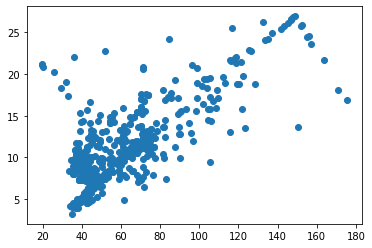

In [35]:
tryingoutput.original_scatter()

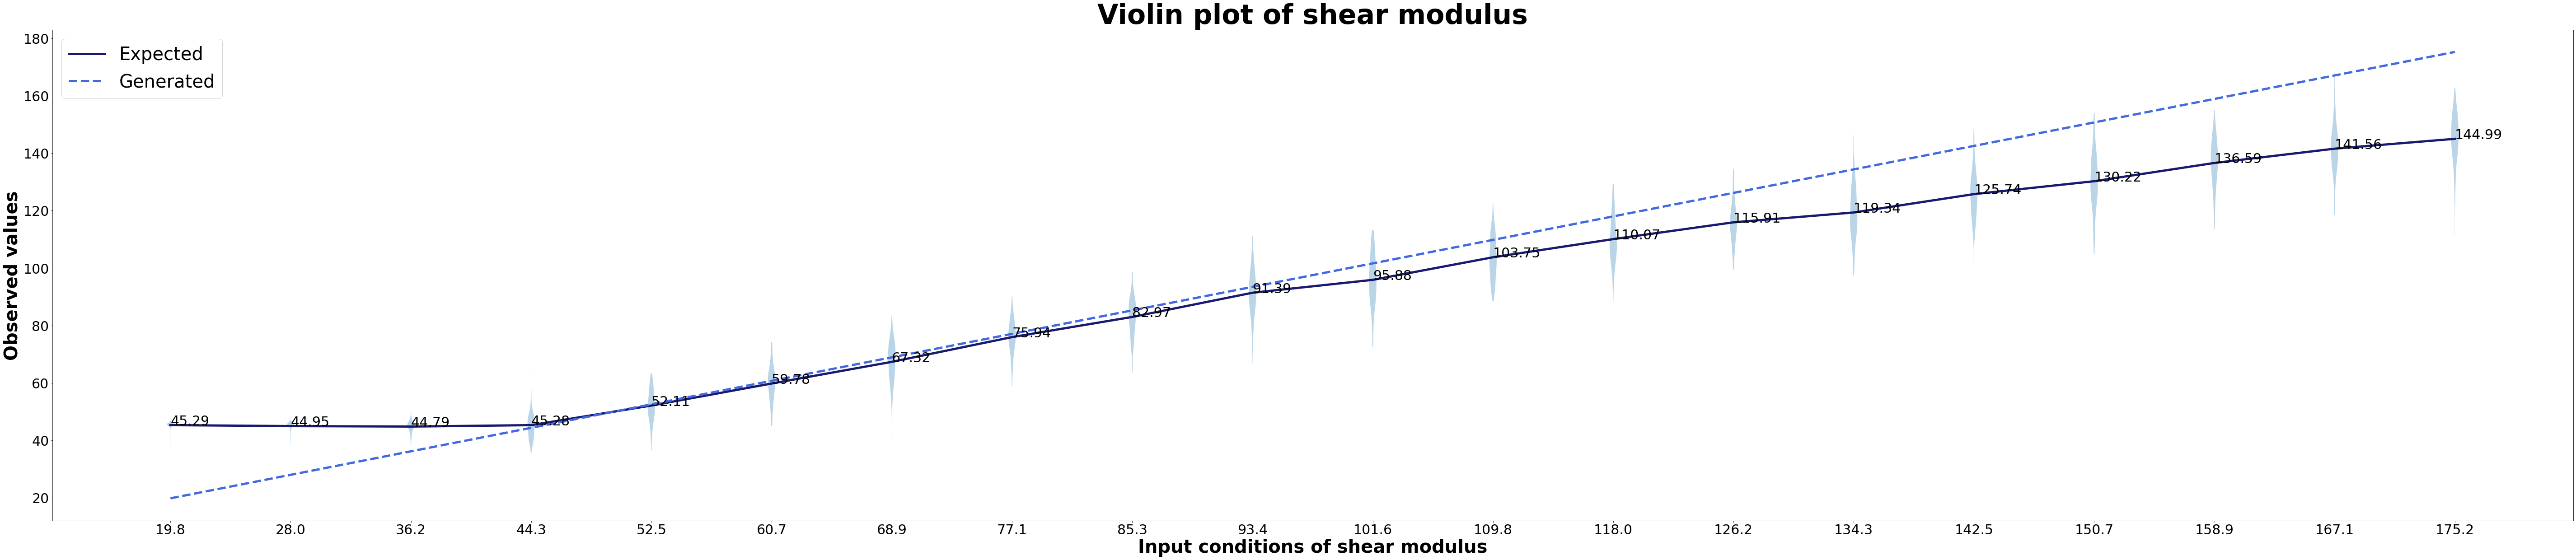

In [36]:
tryingoutput.violin_plot("shear modulus")

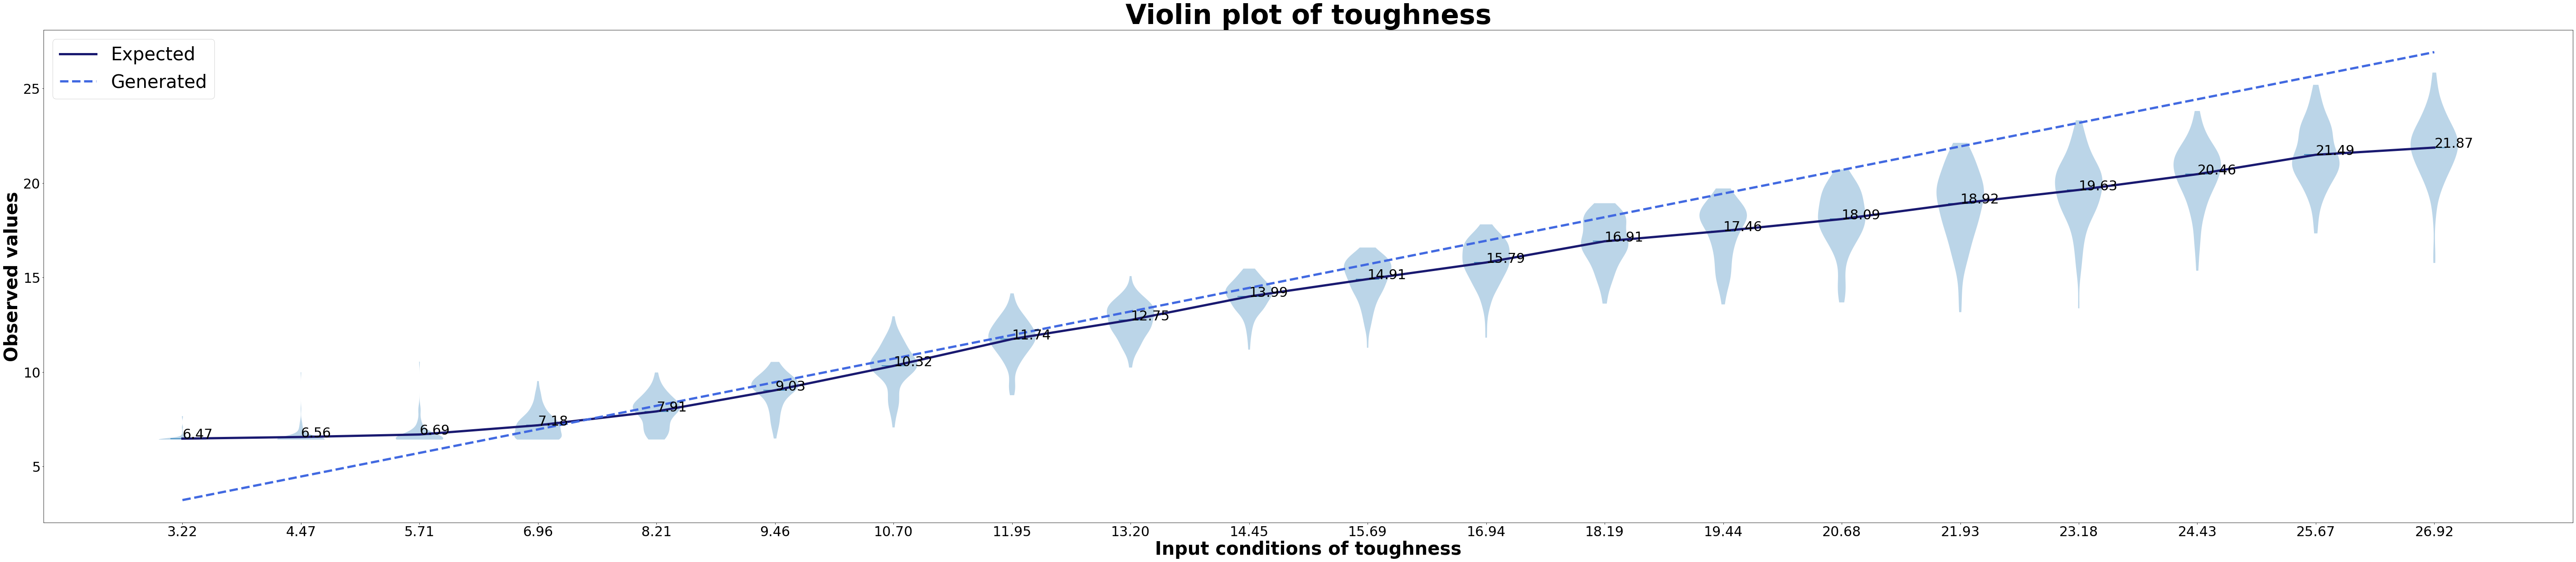

In [37]:
tryingoutput.violin_plot("toughness")

In [38]:
def create_latentcode(rows,latent_range):
  # Create same sets of latent code.
  # 20 100 5
  # 20 2
  latent_output = np.zeros((rows,5))
  for j in range(5):
    latent_output[:,j] = np.random.normal(latent_range[:,j].mean(),latent_range[:,j].std(),rows)
  return torch.from_numpy(latent_output).float()

def create_target_ys(rows,shear_value,toughness_value,Scaler):
  target_ys = np.zeros((rows,2))
  temp_target_ys = Scaler.transform([[shear_value,toughness_value]])
  for i in range(rows):
    target_ys[i] = temp_target_ys
  return torch.tensor(target_ys).float()

In [39]:
print("toughness_min: ",prop_vals[:,0].min())
print("toughness_max: ",prop_vals[:,0].max())
print("shear_min: ",prop_vals[:,1].min())
print("shear_max: ",prop_vals[:,1].max())

toughness_min:  19.804789
toughness_max:  175.247
shear_min:  3.21794
shear_max:  26.921507


[ 19.80478859  37.07614475  54.34750091  71.61885707  88.89021322
 106.16156938 123.43292554 140.7042817  157.97563786 175.24699402]
[[25.889475 23.411713]
 [48.872246 20.46625 ]
 [30.496563 22.399647]
 ...
 [25.238905 22.754745]
 [29.547556 23.941826]
 [30.01908  22.171066]]
[[24.708757 23.062742]
 [16.648428 19.457535]
 [29.150373 22.203823]
 ...
 [35.351273 20.024105]
 [18.743204 19.105507]
 [26.39931  22.796646]]
[[27.361273 21.138838]
 [38.086937 17.848038]
 [25.602633 19.673504]
 ...
 [25.248034 19.037895]
 [16.944765 19.987915]
 [33.79267  19.060852]]
[[26.262224 17.69125 ]
 [23.407148 17.08543 ]
 [26.139425 16.25049 ]
 ...
 [20.225111 18.953917]
 [30.170801 15.567766]
 [18.462862 18.437233]]
[[35.03815   11.816628 ]
 [29.224043  13.039981 ]
 [17.859549  16.698078 ]
 ...
 [32.735195  13.3462105]
 [40.113235  14.746423 ]
 [14.45304   15.85746  ]]
[[32.00847   9.522809]
 [22.178793 13.431956]
 [25.211454 13.079219]
 ...
 [38.335636 10.998915]
 [28.081614 11.301252]
 [21.032019 11.

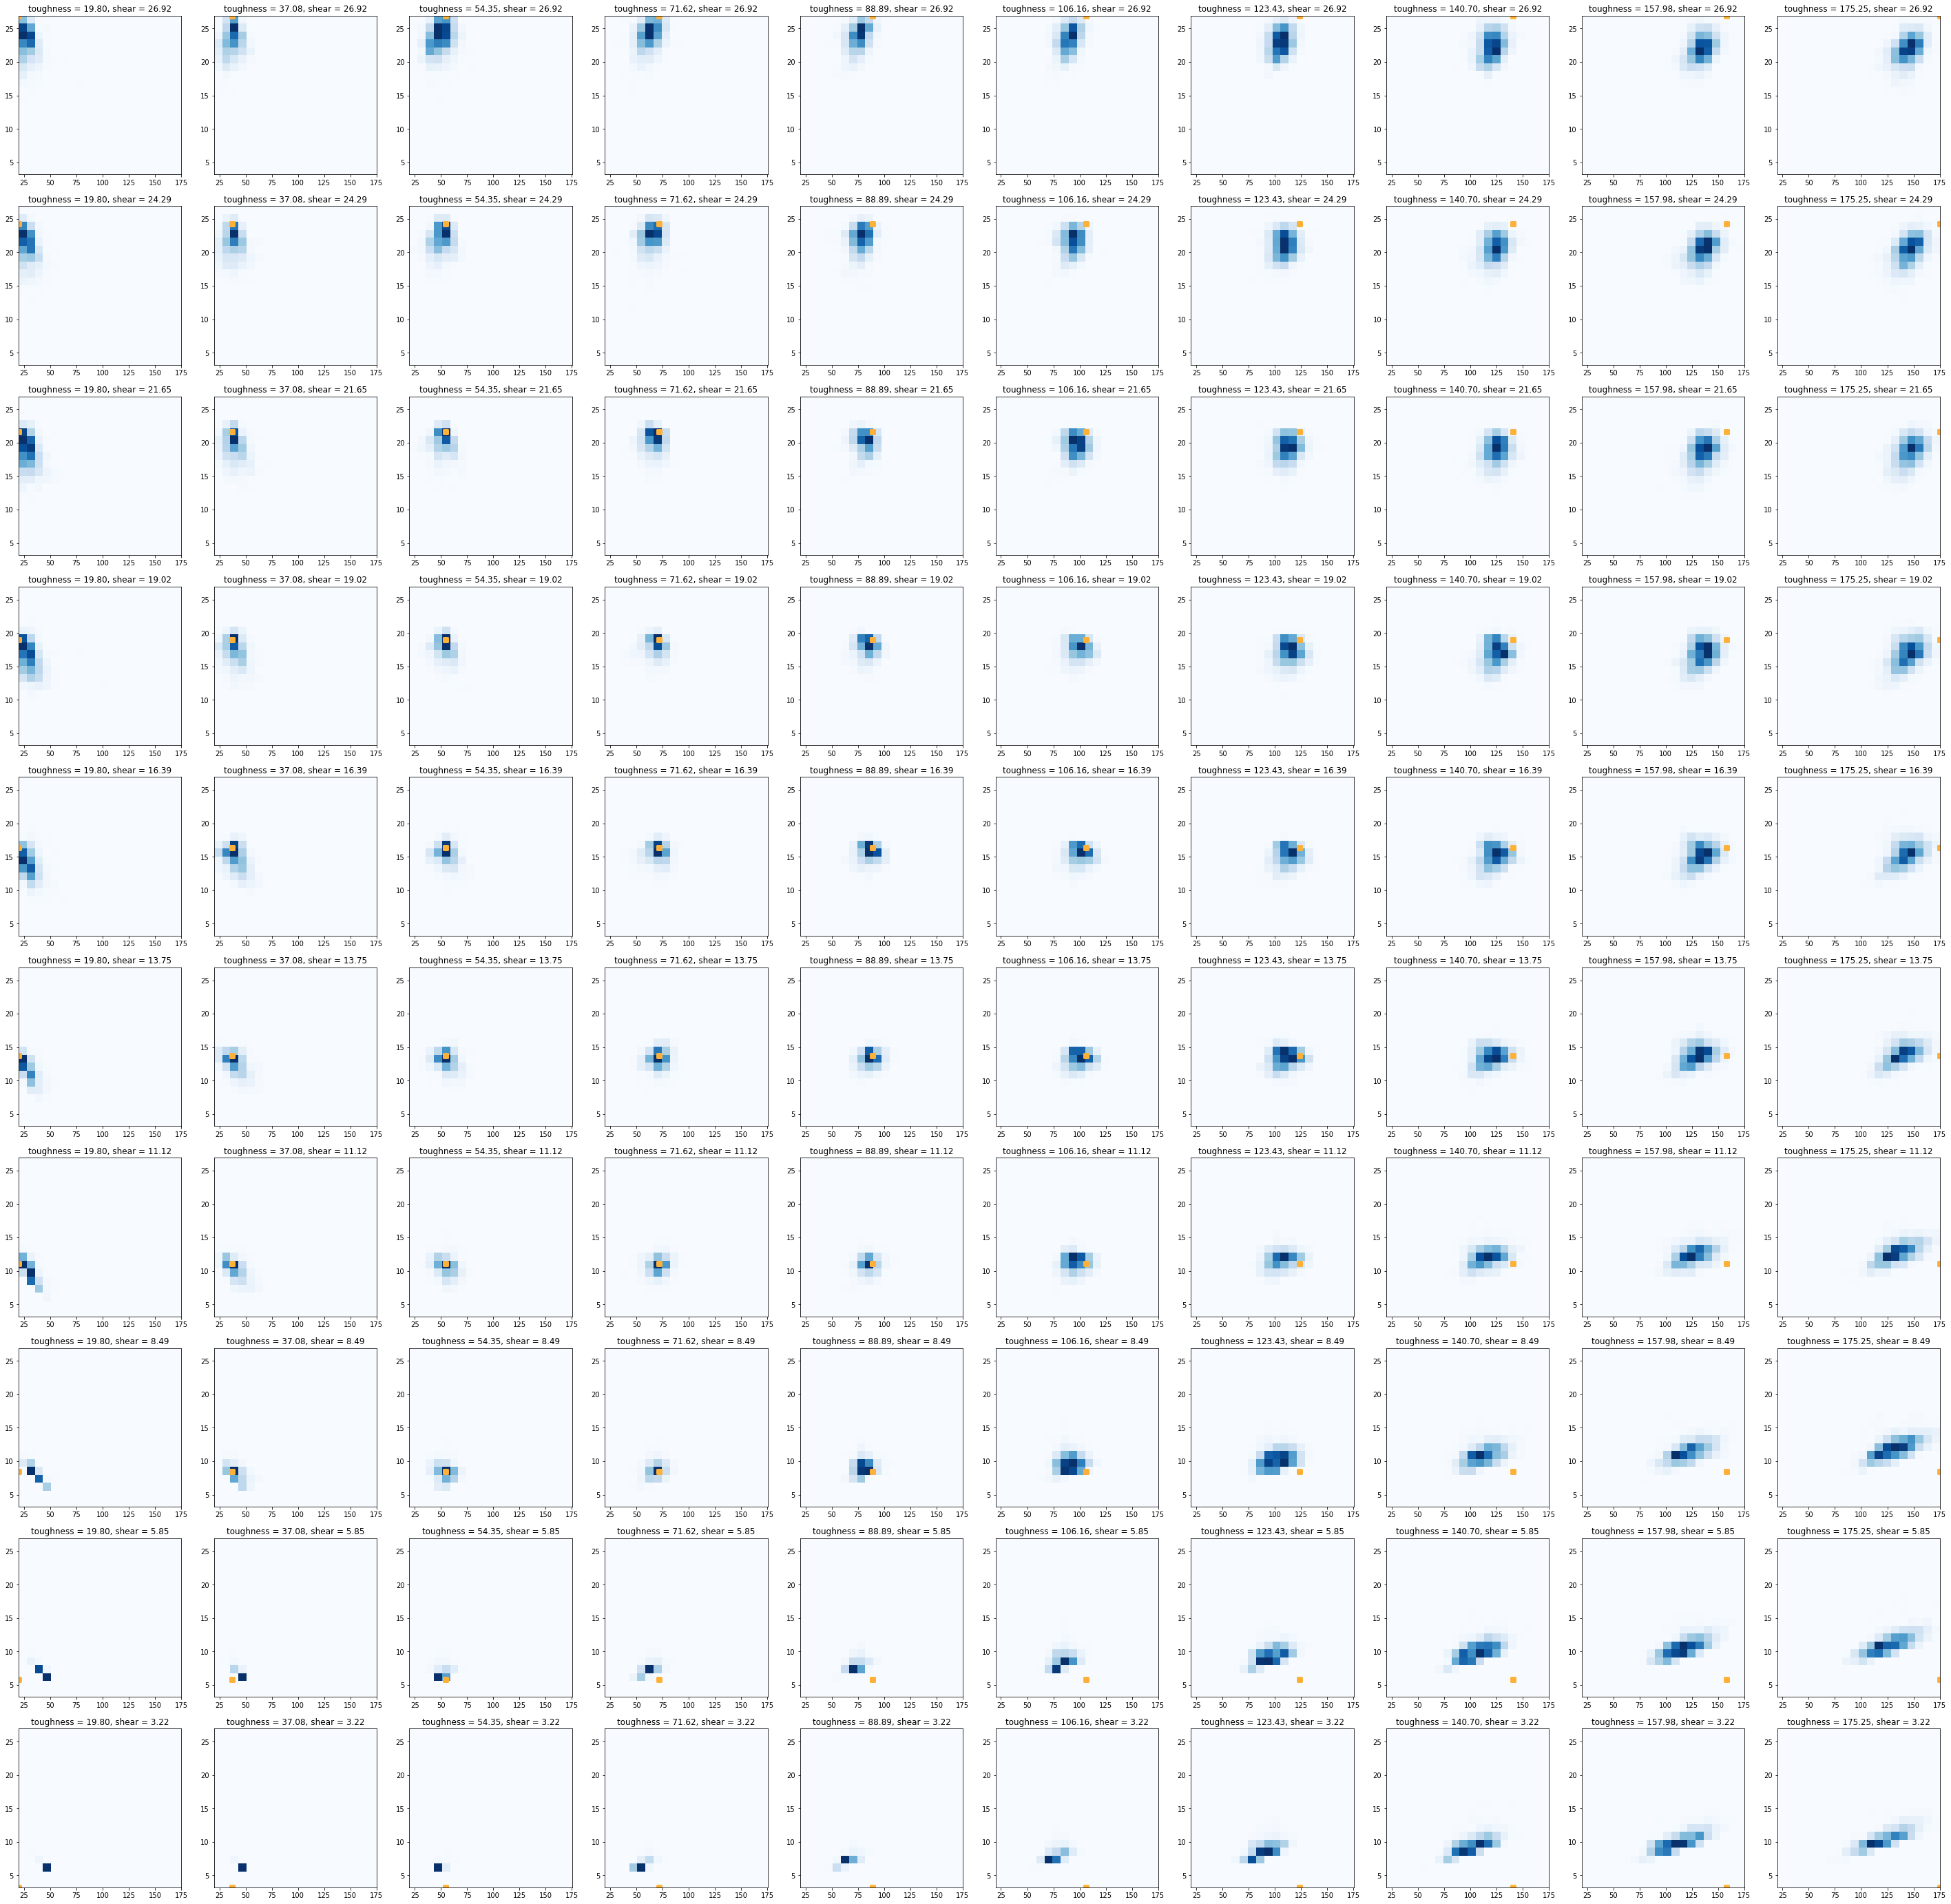

In [45]:
histo_dist = plt.subplots(10,10,figsize=(50,50))
over_t=0
over_s=0
input_toughness = np.linspace(prop_vals[:,0].min(),prop_vals[:,0].max()+over_t,10)
input_shear = np.linspace(prop_vals[:,1].max()+over_s,prop_vals[:,1].min(),10)
print(input_toughness)
for i in range(10): #shear
  for j in range(10): #toughness
    latent_value=create_latentcode(2000,a_pred)
    target_ys = create_target_ys(2000,input_toughness[i],input_shear[j],scaler)
    forim = scaler.inverse_transform(s_ANN(model.decode(latent_value,target_ys)).detach().numpy())
    print(forim)
    histo_dist[1][j][i].hist2d(forim[:,0],forim[:,1],bins=20,range=np.array([[prop_vals[:,0].min(),prop_vals[:,0].max()+over_t],[prop_vals[:,1].min(),prop_vals[:,1].max()+over_s]]),cmap='Blues') #Blues
    histo_dist[1][j][i].scatter(input_toughness[i],input_shear[j],marker = 's',color ='#FEB139',linewidths = 3)
    histo_dist[1][j][i].set_title('toughness = {t:.2f}, shear = {s:.2f}'.format(t=input_toughness[i],s=input_shear[j]))

In [44]:
a_pred.shape

(529, 5)

## Explore variance

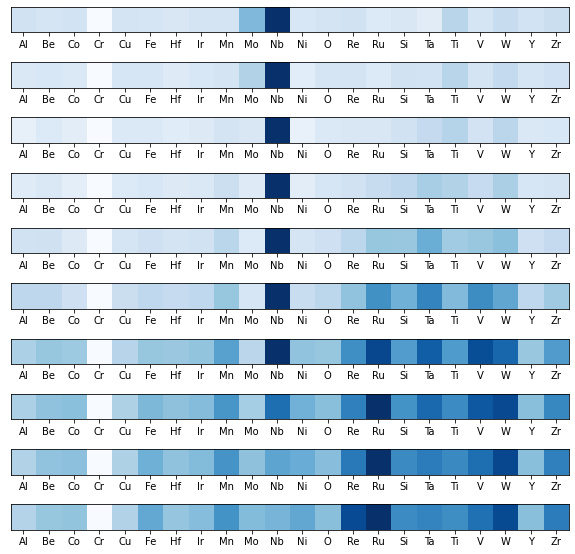

In [41]:
rows = 10
latent_fixed_var = create_latentcode(1,a_pred)
ys_var_toughness = np.linspace(40,150,rows)
ys_var_shear = np.linspace(10,10,rows)
fig, axes = plt.subplots(rows,1,figsize=(10,rows))
for i in range(rows):
  ys_var = create_target_ys(1,ys_var_toughness[i],ys_var_shear[i],scaler)
  axes[i].imshow(model.decode(latent_fixed_var,ys_var).detach().numpy(),cmap='Blues')
  plt.setp(axes[i],yticks = [], yticklabels=[],xticks=[i for i in range(22)],xticklabels=dset.elements)
# plt.setp(axes,yticks = [], yticklabels=[],xticks=[i for i in range(22)],xticklabels=dset.elements)